In [1]:
#Librerias basicas
import pandas as pd
import numpy as np

#Libreria para crear la linea 3D
from skspatial.objects import Line
from skspatial.objects import Points

#Librerias de graficas
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as m3d


## Generalidades
Para este proyecto crearemos unos datos que tiene como referencia el crecimiento y desarrollo de los frutos de durazno por lo cual tenemos el tiempo (time), el diametro ecuatorial (dEcua) y el diametro Longitudinal (dLong).

In [2]:
#Creamos una funcion para ver los resultados de la creacion de la linea 3D
def scatter_plot_3D(datos,linea):
  ax = m3d.Axes3D(plt.figure(figsize=(10,7)))
  ax.plot3D(*linea.T, c="red", linewidth=5)
  ax.scatter3D(*datos.T,marker=".",c="black")
  ax.view_init(10,315)
  ax.set_xlabel("Time")
  ax.set_ylabel("Equatorial Diameter")
  ax.set_zlabel("Longitudinal Diameter")
plt.show()

In [3]:
#Creamos una funcion para darle aletoridad a los datos creados
def aletoridad_datos(datos,delta):
  datos = datos + np.random.normal(size=datos.shape) * delta
  return datos

## Paso 1: Creacion de los datos 
1. Creamos una linea de datos original
2. A esta linea le agregamos aletoridad para asi obtener una nube de puntos con tendencia a ser una linea 3D
3. Graficamos la linea original y la nube de puntos para ver el resultado al cual queremos llegar con la nube de puntos.

In [4]:
# Creamos un datos para time ,dEcu y dLong como ejemplo
#los rangos de estos datos estan basados en el desarrollo de frutos de durazno
x = np.mgrid[0:200:120j] #tiempo
y = np.mgrid[0:6:120j] #diametro ecuatorial
z = np.mgrid[0:6:120j] #diametro longitudinal

data = np.concatenate((x[:, np.newaxis], 
                       y[:, np.newaxis], 
                       z[:, np.newaxis]), 
                      axis=1)

In [5]:
#agregamos algo de aletoridad en los datos.
data_1=aletoridad_datos(data,1)

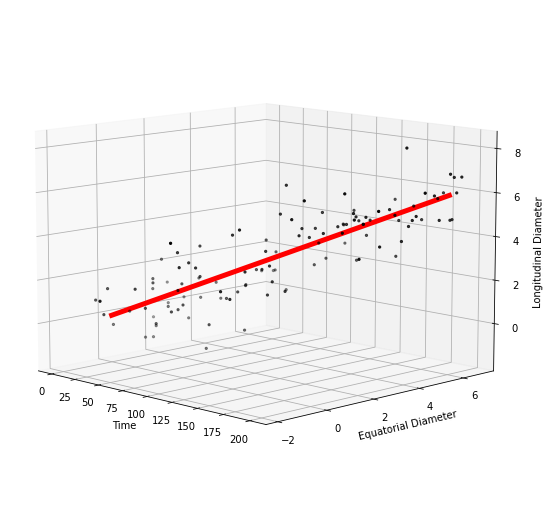

In [6]:
#veamos nuestros datos en una grafica
scatter_plot_3D(data_1,data)

## Paso 2: Ajuste linea 3D
Para la creacion de la linea 3D:
1. Calculamos la media de la nube de puntos.
2. Usando SVD para la diferencia entre los datos y la media.
3. Usando unos de los componente creamos los datos de la linea.
4. Extraemos un punto y un vector para tener la formula no parametrica.
5. Con el punto y el vector recreamos los valores que encagen con las dimenciones de nuestra linea de puntos

In [7]:
#Creamos una funcion que usando SVD(Singular Value Decomposition) nos permite crear el vector para nuestra linea 3D
def linea_3d(array):
  #Se calcula la media de la nube de puntos
  datamean = array.mean(axis=0)
  # Se realiza un SVD(Singular Value Decomposition) entre la media y los datos
  uu ,dd ,vv = np.linalg.svd(array-datamean)
  ## el componente vv[0]  es el primer componente principal. Nos da la direccion
  linea_3d=vv[0] *  np.mgrid[-7:7:2j][:, np.newaxis]
  ## Operamos los datos creados con nuestra data promedio para encontrar los puntos de nuestra linea 3d
  linea_3d += datamean
  punto = linea_3d[0]
  vector = linea_3d[1]-linea_3d[0]
  return punto, vector


In [8]:
#Funcion para construir la linea3D a partir de la nube de puntos usando un punto y el vector generados anteriormente,
def Construir_linea3D(datos,punto,vector):
  n= len(datos)
  matriz = np.zeros(shape=(n,3))
  for i in range(n):
      alpha=((datos[i][0])-punto[0])/vector[0]
      punto_calc=punto+(alpha*vector)
      matriz[i]=punto_calc
  return matriz 

In [9]:
punto_R3, vector_R3 = linea_3d(data_1)

In [10]:
Linea3D=Construir_linea3D(data_1,punto_R3,vector_R3)

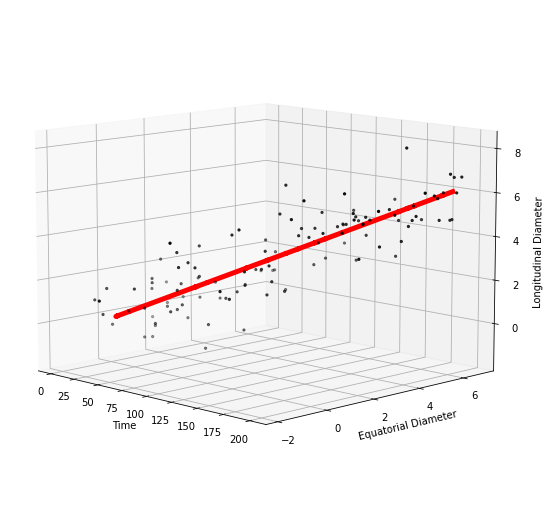

In [11]:
scatter_plot_3D(data_1,Linea3D)

## Paso 3: Ajuste linea 3D con Scikit-spatial
Vamos a utilizar la libreria scikit-spatial para generar la linea 3D.

In [12]:
points = Points(data_1)
line_fit = Line.best_fit(points)
punto2_R3=np.array(line_fit.point)
vector2_R3=np.array(line_fit.vector)

In [13]:
Linea2_3D=Construir_linea3D(data_1,punto2_R3,vector2_R3)

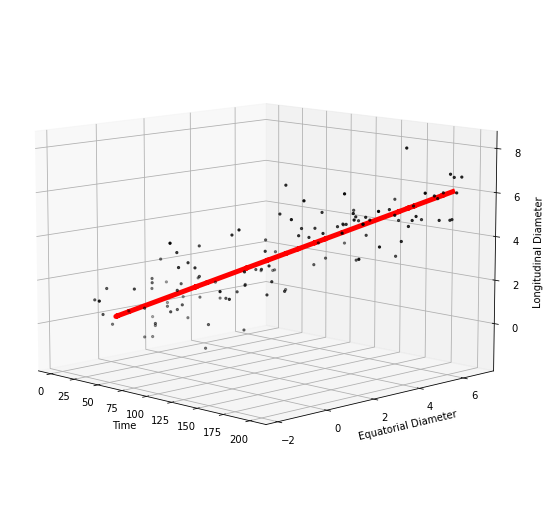

In [14]:
scatter_plot_3D(data_1,Linea2_3D)

## Paso 4: Comparacion de los resultados
Vamos a comparar la linea original (azul) con las generadas por el metodo programado (roja) y la generada por la libreria scikit-spatial

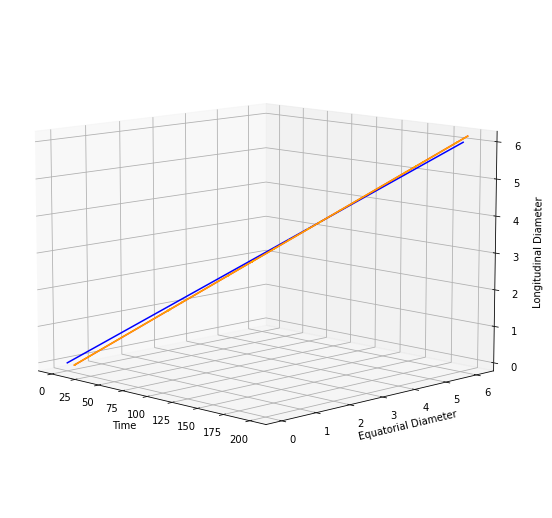

In [17]:
#Confirmacion del exito de la creacion de la linea 3d usando los dos metodos
ax = m3d.Axes3D(plt.figure(figsize=(10,7)))
#ax.scatter3D(*data_1.T)
ax.plot3D(*data.T,"blue")
ax.plot3D(*Linea3D.T, "red")
ax.plot3D(*Linea2_3D.T, "orange")
ax.view_init(10, 315)
ax.set_xlabel("Time")
ax.set_ylabel("Equatorial Diameter")
ax.set_zlabel("Longitudinal Diameter")
plt.show()

#### Podemos ver que efectivamente ambos metodos son equivalentes y se acercan mucho a la linea original.

## Paso 5: Obtencion de la ecuación parametrica.
La ecuación vectorial para una linea 3D se puede definir de la siguiente manera:
$$ (x,y,z)=(x_{0},y_{0},z_{0})+ \alpha(v_{1},v_{2},v_{3})$$
Para nuestra linea 3D de frutos de durazno seria:
$$ (x,y,z)=(100.07,3.149, 3.051)+ \alpha(0.999198, 0.02996106,0.02656469)$$


Sin embargo tambien podemos encontrar la ecuacion parametrica.
Esta esta definida de la siguiente manera:
$$\frac{x-x_{0}}{v1}=\frac{y-y_{0}}{v2}=\frac{z-z_{0}}{v3}$$
Para este caso utilizaremos la libreria sympy

In [ ]:
import sympy as s

In [ ]:
#Funcion para generar la ecuacion parametrica
def ecuacion(punto,vector):
  x,y,z,a = s.symbols('x y z a')
  a1=punto[0]+(vector[0]*a)-x
  a2=punto[1]+(vector[1]*a)-y
  a3=punto[2]+(vector[2]*a)-z
  sol1=s.solve(a1,a)
  sol2=s.solve(a2,a)
  sol3=s.solve(a3,a)
  ecuX=s.nsimplify(sol1[0], tolerance=0.0001)
  ecuY=s.nsimplify(sol2[0], tolerance=0.0001)
  ecuZ=s.nsimplify(sol3[0], tolerance=0.0001)
  return ecuX, ecuY, ecuZ

In [ ]:
ecuacion(punto2_R3,vector2_R3)

### Ecuacion vectorial
$$ (x,y,z)=(100.07,3.149, 3.051)+ \alpha(0.999198, 0.02996106,0.02656469)$$

### Ecuacion parametrica
$$\frac{9975x}{9967}-\frac{849628}{8483} = \frac{12583y}{377}-\frac{653630}{6217}=\frac{71260z}{1893}-\frac{891467}{7760}$$